# Zero-shot reference mapping tutorial with scGPT

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under `data` directory in the outer level.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y). 


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Generate scGPT embeddings for each cell in reference and query datasets

 3. Transfer the annotations from reference to query dataset

At the [appendix](#appendix-reference-mapping-on-lung-kim-dataset) of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).


We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb)

In [1]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain faiss-cpu

    # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "covid")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS",
            output=os.path.join(data_dir),
        )
    if not os.path.exists(os.path.join(data_dir, "lung")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO",
            output=os.path.join(data_dir),
        )

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_human"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
            output=model_dir,
        )

## Import scGPT and dependencies

In [36]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import torch
sys.path.insert(0, "../")

import faiss
from sklearn.preprocessing import LabelEncoder

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

In [3]:
dataDir = Path(f"/home/s5srinivasan/covid-annotation-scgpt/data")
modelDir = Path(f"/home/s5srinivasan/covid-annotation-scgpt/save/randomModel") # use of random model
modelPath = Path(f"/home/s5srinivasan/covid-annotation-scgpt/save/randomModel/best_model.pt") # use of random model

In [16]:
referenceData = sc.read(dataDir/"covidData.h5ad")
queryData = sc.read(dataDir/"blishLabPBMCCovid.h5ad")

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_io/specs/registry.py:275: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_io/specs/registry.py:275: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_io/specs/registry.py:275: OldFormatWarning: Element '/layers/matrix' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_io/specs/registry.py:275: OldFormatWarning: Element '/layers/norm_data' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/home/s5srinivasan/py39env/lib64/python3.9/site-packages

In [19]:
referenceData.obs.celltype.value_counts()

celltype
CD14+ Monocytes                 103659
NK cells                         50878
CD4+ T cells                     46341
Naïve CD4+ T cells               40515
CD8+ T cells                     36915
Naïve B cells                    21080
Non-switched memory B cells       9866
CD16+ Monocytes                   8955
MAIT cells                        7998
Low-density neutrophils           7953
Megakaryocytes                    7196
Intermediate monocytes            5857
gd T cells                        5715
Plasmablasts                      4879
Naïve CD8+ T cells                4818
Myeloid dendritic cells           4737
Plasmacytoid dendritic cells      3598
B lymphoblast                     3248
CD34+ Progenitor cells             971
Low-density basophils              259
Name: count, dtype: int64

Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [20]:
queryData.obs.rename(columns={'singler':'celltype'},inplace=True) # rename cell type column

In [21]:
queryData.var.index.name = "gene_name" # rename var.index

In [22]:
queryData.var['gene_name'] = queryData.var.index # copy index to a separate column

In [25]:
cell_type_key = "celltype"
gene_col = "gene_name"

Embed the reference dataset

In [27]:
ref_embed_referenceData = scg.tasks.embed_data(
    referenceData,
    modelDir,
    gene_col=gene_col,
    batch_size=240,
)

scGPT - INFO - match 13704/14063 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 1565/1565 [24:18<00:00,  1.07it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


Embed the query dataset

In [28]:
test_embed_queryData = scg.tasks.embed_data(
    queryData,
    modelDir,
    gene_col=gene_col,
    batch_size=240
)

scGPT - INFO - match 22619/26361 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 187/187 [02:24<00:00,  1.30it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Mark the reference vs. query cells and mask the cell types on query cells

In [29]:
# concatenate the two datasets
referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")

/tmp/ipykernel_441783/3134427906.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [30]:
# mark the reference vs. query dataset
referenceData_concat.obs["is_ref"] = ["Query"] * len(test_embed_queryData) + ["Reference"] * len(
    ref_embed_referenceData
)
referenceData_concat.obs["is_ref"] = referenceData_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].astype("category")
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"

/tmp/ipykernel_441783/3863382858.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"


In [31]:
referenceData_concat.obs

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,Severity,log10GenesPerUMI,percent.mt,percent.Heme,Study,new.annot2,celltype_id,batch_id,dataset,is_ref
covid_555_1.1-0,ICU,13,9.0,9.0,C1 A,-0.026053,0.015625,M,COVID,NonVent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
covid_555_1.2-0,ICU,10,9.0,9.0,C1 A,0.023525,-0.000322,M,COVID,NonVent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
covid_555_1.3-0,ICU,19,9.0,9.0,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
covid_555_1.7-0,ICU,10,9.0,9.0,C1 A,-0.038040,0.022590,M,COVID,NonVent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
covid_555_1.8-0,ICU,22,9.0,9.0,C1 A,-0.043605,0.010739,M,COVID,NonVent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Query
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTACCTTACACTCGAGAAAGGGTCAG_22_5-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Healthy,0.882532,21.009867,0.000000,SS_C2,8.0,9.0,3.0,1,Reference
AACTGTATTACTATCCTCCTAGATAGA_22_5-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Non-severe,0.907000,20.129870,0.779221,SS_C2,4.0,1.0,3.0,1,Reference
CACATTGCAGCTAACTCACAGGCATTT_22_5-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Healthy,0.931754,17.892644,0.397614,SS_C2,4.0,1.0,3.0,1,Reference
TCTCTTCAACAATTGATCAGCCGCAAG_22_5-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Severe,0.940330,13.244353,0.410678,SS_C2,2.0,5.0,3.0,1,Reference


## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

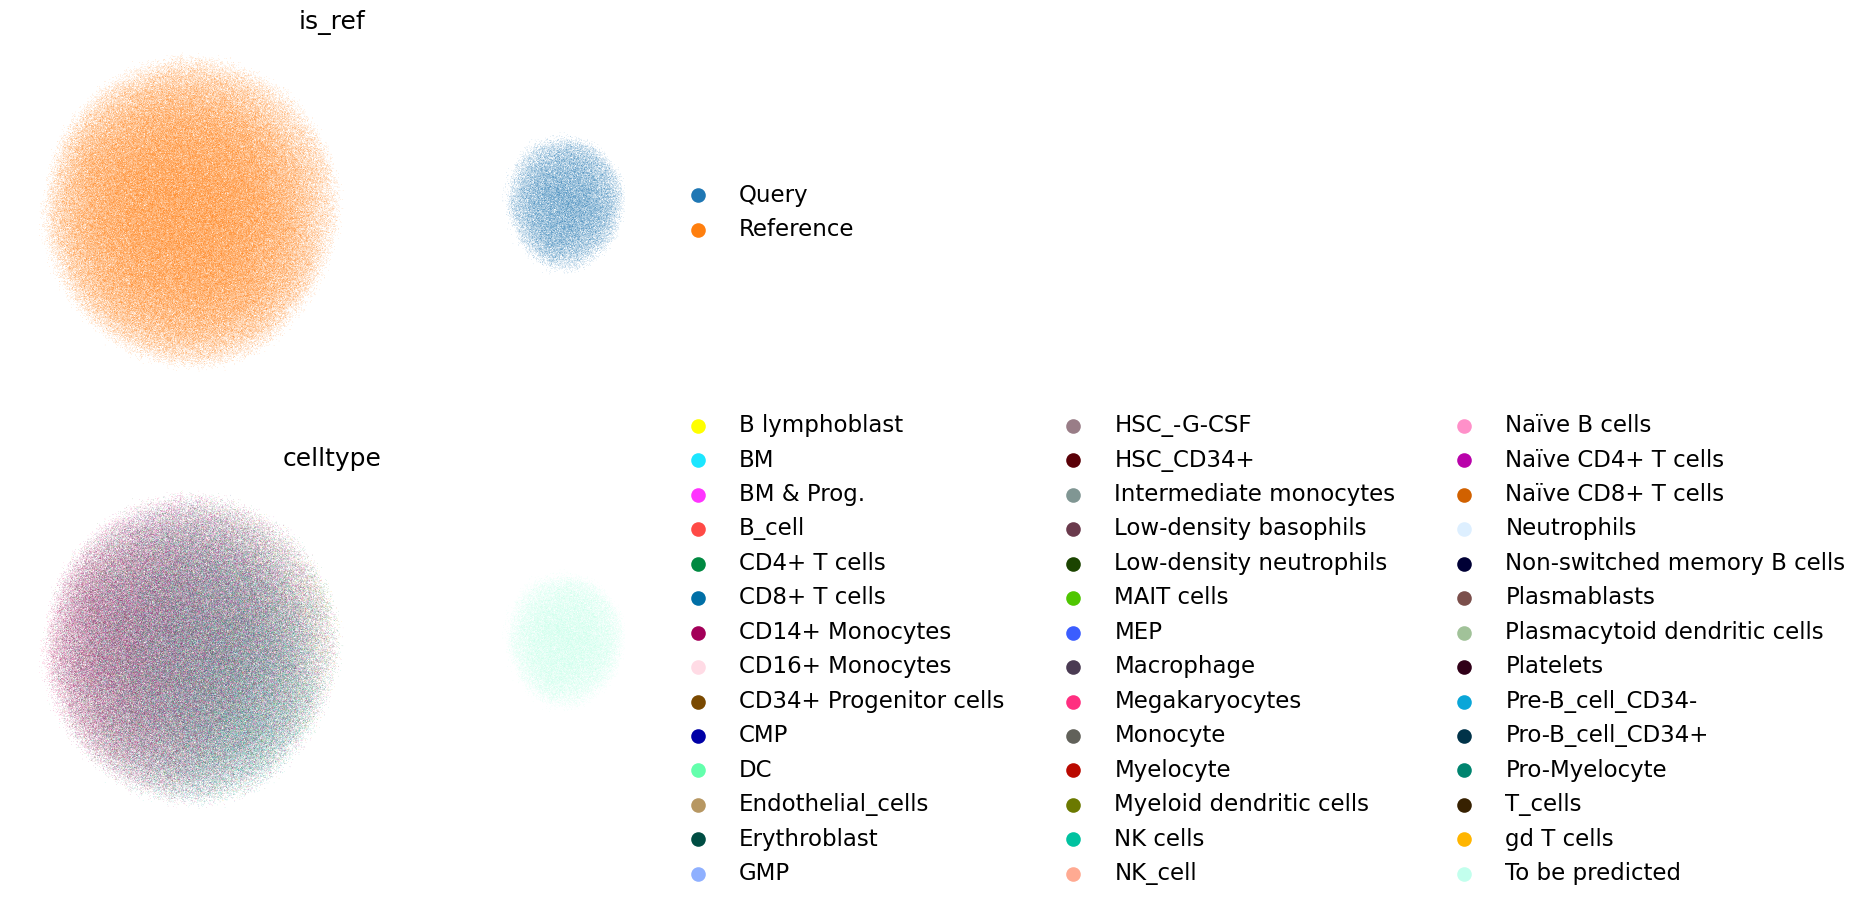

In [32]:
sc.pp.neighbors(referenceData_concat, use_rep="X_scGPT")
sc.tl.umap(referenceData_concat)
sc.pl.umap(
    referenceData_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations

Run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [33]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [55]:
test_embed_queryData.write_h5ad('/home/s5srinivasan/covid-annotation-scgpt/data/test_embed_queryData.h5ad')
ref_embed_referenceData.write_h5ad('/home/s5srinivasan/covid-annotation-scgpt/data/ref_embed_referenceData.h5ad')

In [93]:
ref_cell_embeddings = ref_embed_referenceData.obsm["X_scGPT"]
test_embed = test_embed_queryData.obsm["X_scGPT"]

k = 50  # number of neighbors

In [80]:
test_embed_queryData

AnnData object with n_obs × n_vars = 44721 × 22619
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'celltype'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance', 'gene_name', 'id_in_vocab'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap', 'X_scGPT'
    varm: 'pca_feature_loadings'
    layers: 'matrix', 'norm_data', 'scale_data'

In [94]:
# Ensure both the query data (test_embed) and reference data (ref_cell_embeddings) are on GPU
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create GPU resources for FAISS
res = faiss.StandardGpuResources()

# If ref_cell_embeddings is a PyTorch tensor, convert it to NumPy
if isinstance(ref_cell_embeddings, torch.Tensor):
    ref_cell_embeddings = ref_cell_embeddings.cpu().numpy()  # FAISS requires NumPy arrays

# Initialize FAISS index
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])  # L2 distance metric
index.add(ref_cell_embeddings)  # Add reference embeddings to the index

# Transfer FAISS index to GPU
index_gpu = faiss.index_cpu_to_gpu(res, 0, index)

# If test_embed is a PyTorch tensor, convert it to NumPy before searching
if isinstance(test_embed, torch.Tensor):
    test_embed = test_embed.cpu().numpy()

# Perform search on GPU
distances, labels = index_gpu.search(test_embed, k)

# Initialize lists to store predictions and similarity scores
preds = []
sim_list = distances

# Encode cell type labels into integers
cell_type_labels = ref_embed_referenceData.obs[cell_type_key].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(cell_type_labels)

# Convert encoded labels to a PyTorch tensor on GPU
ref_cell_types = torch.tensor(encoded_labels, device=device)

# Convert FAISS output labels to PyTorch tensor on GPU
labels_tensor = torch.tensor(labels, device=device)

# Perform cell type prediction using nearest neighbors
for i in range(test_embed.shape[0]):
    # Get the indices of the k nearest neighbors
    idx = labels_tensor[i]

    # Get the cell types for the closest reference neighbors
    nearest_cell_types = ref_cell_types[idx]

    # Count the most common cell type in the closest neighbors
    unique_cell_types, counts = torch.unique(nearest_cell_types, return_counts=True)

    # Get the most common cell type (mode)
    pred = unique_cell_types[torch.argmax(counts)].item()
    preds.append(pred)

# Convert ground truth cell type labels to NumPy array
gt = test_embed_queryData.obs[cell_type_key].to_numpy()

## Evaluate the performance

In [95]:
preds_str = label_encoder.inverse_transform(preds)
np.unique(preds_str)

array(['CD14+ Monocytes', 'CD4+ T cells'], dtype=object)

In [96]:
# Now calculate metrics
res_dict = {
    "accuracy": accuracy_score(gt, preds_str),
    "precision": precision_score(gt, preds_str, average="macro"),
    "recall": recall_score(gt, preds_str, average="macro"),
    "macro_f1": f1_score(gt, preds_str, average="macro"),
}

res_dict

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'macro_f1': 0.0}

Confusion matrix:

/tmp/ipykernel_441783/3308124233.py:5: RuntimeWarning: invalid value encountered in divide
  matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]


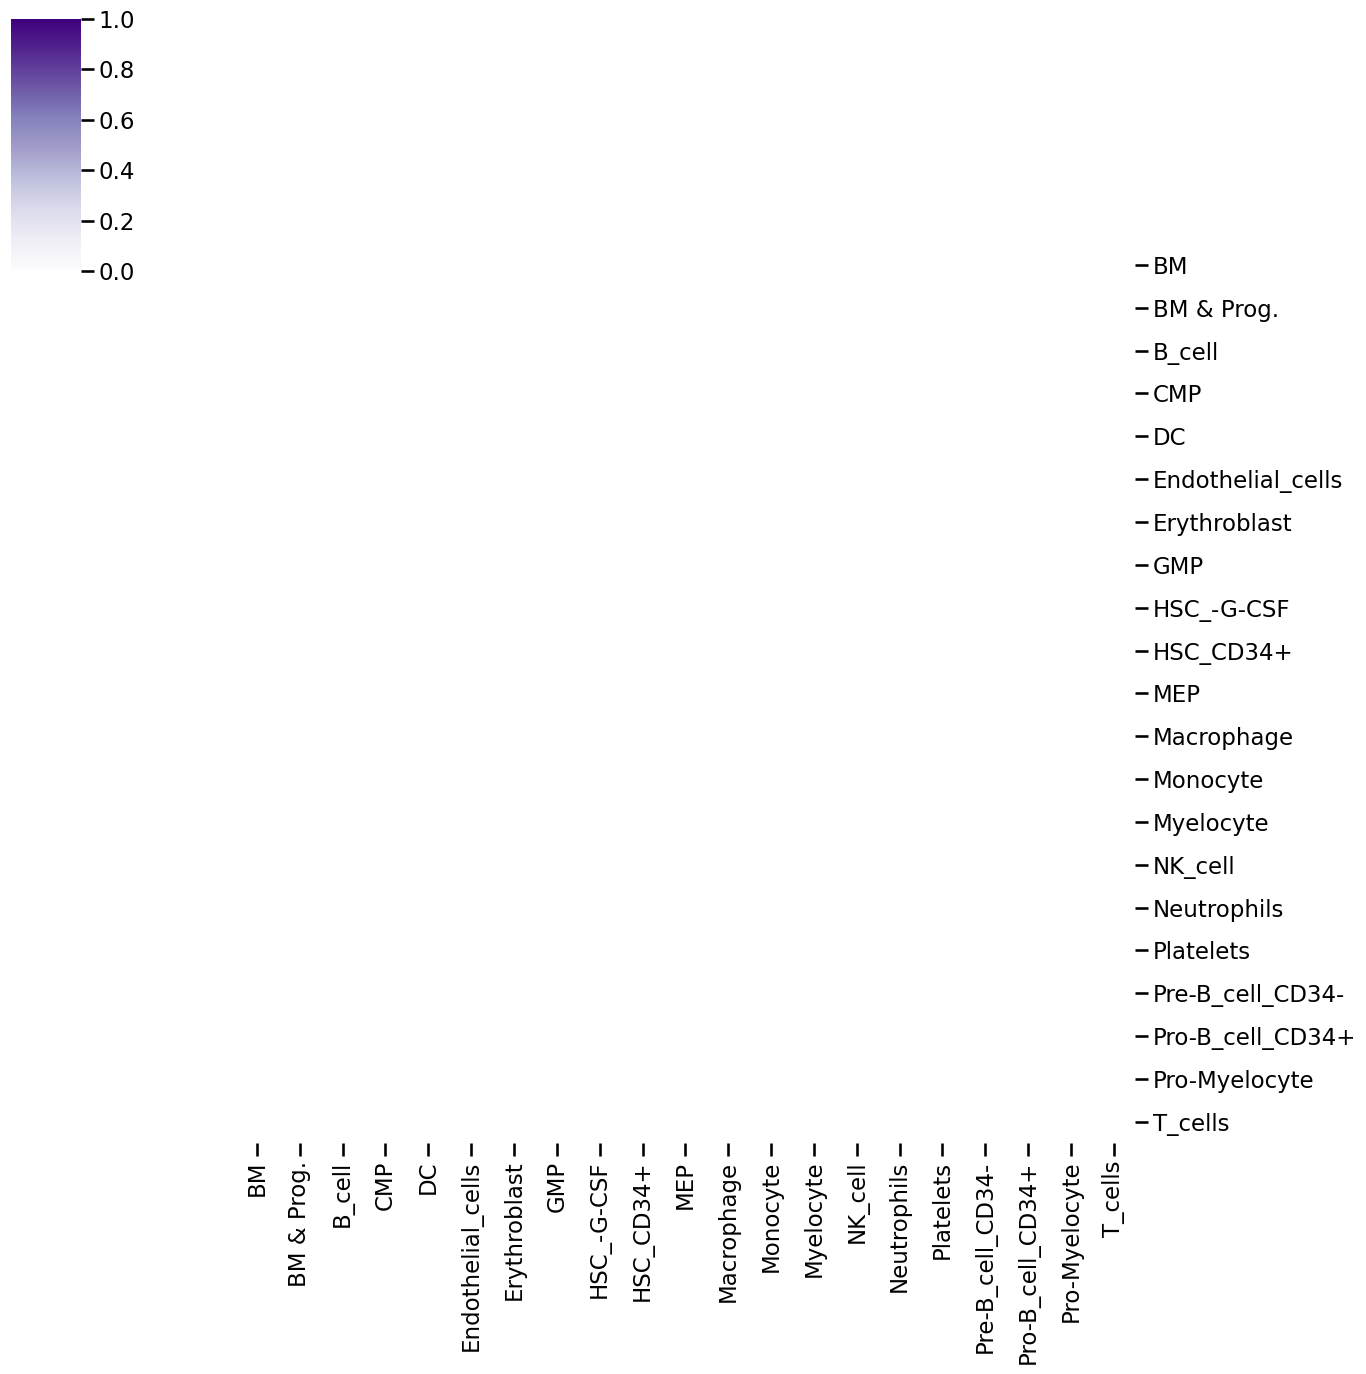

In [61]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

## Appendix: Reference mapping on Lung-Kim dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).

In [ ]:
referenceData = sc.read_h5ad('../../data/lung/sample_proc_lung_train.h5ad')
queryData = sc.read_h5ad('../../data/lung/sample_proc_lung_test.h5ad')

sc.pp.normalize_total(referenceData, target_sum=1e4)
sc.pp.log1p(referenceData)
sc.pp.normalize_total(queryData, target_sum=1e4)
sc.pp.log1p(queryData)

gene_col = "gene_name"
cell_type_key = "cell_type"

In [ ]:
ref_embed_referenceData = scg.tasks.embed_data(
    referenceData,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
test_embed_queryData = scg.tasks.embed_data(
    queryData,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# concatenate the two datasets
referenceData_concat = test_embed_queryData.concatenate(ref_embed_referenceData, batch_key="dataset")
# mark the reference vs. query dataset
referenceData_concat.obs["is_ref"] = ["Query"] * len(test_embed_queryData) + ["Reference"] * len(
    ref_embed_referenceData
)
referenceData_concat.obs["is_ref"] = referenceData_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
referenceData_concat.obs[cell_type_key] = referenceData_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
referenceData_concat.obs[cell_type_key][: len(test_embed_queryData)] = "To be predicted"

In [ ]:
sc.pp.neighbors(referenceData_concat, use_rep="X_scGPT")
sc.tl.umap(referenceData_concat)
sc.pl.umap(
    referenceData_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [30]:
ref_cell_embeddings = ref_embed_referenceData.obsm["X_scGPT"]
test_embed = test_embed_queryData.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_referenceData.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = queryData.obs[cell_type_key].to_numpy()

In [ ]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

In [ ]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,
                    fmt=".2f", 
                    annot_kws={'size': 16}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

# Classification

In [4]:
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
import anndata
import scanpy as sc
# import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics
sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [3]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="covid",
    do_train=True,
    load_model="/tscc/nfs/home/s5srinivasan/scgpt-project/covid-annotation-scgpt/save/scGPT-human",
    mask_ratio=0.0,
    epochs=10,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=32, #rtx3090 - 18, a100 - 32, v100 - 24
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [5]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT-covid-annotation",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: srks (srks-uc-san-diego). Use `wandb login --relogin` to force relogin


{'seed': 0, 'dataset_name': 'covid', 'do_train': True, 'load_model': '/tscc/nfs/home/s5srinivasan/scgpt-project/covid-annotation-scgpt/save/scGPT-human', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [6]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [ ]:
modelDir = Path(f"/home/s5srinivasan/covid-annotation-scgpt/save/randomModel") # use of random model
dataDir = Path(f"/home/s5srinivasan/covid-annotation-scgpt/save/") # setting up data and project directories

# referenceData = sc.read(dataDir / "covidData.h5ad") # Mukund et al. reference dataset
queryData = sc.read(dataDir / "may24_covid19.h5ad") # May et al. query dataset

# projectDir = Path(f"/tscc/nfs/home/s5srinivasan/scgpt-project/covid-annotation-scgpt")